In [62]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as Func

from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim

from sklearn.model_selection import train_test_split

import pennylane as qml

import matplotlib.pyplot as plt
import h5py

In [63]:
transform = transforms.Compose(
    [
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [64]:
with h5py.File('Galaxy10_DECals.h5', 'r') as file:
    images = np.array(file['images'])
    classes = np.array(file['ans'])
    dec = np.array(file['dec'])
    pxscale = np.array(file['pxscale'])
    re = np.array(file['ra'])
    redshift = np.array(file['redshift'])
    print("Keys: %s" % file.keys())

#images, labels - галактики и их классы, dec, pxscale, re, redshift вряд ли пригодятся

Keys: <KeysViewHDF5 ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']>


In [65]:
classes_names = { 
            0: "Disturbed Galaxy",
            1: "Merging Galaxy",
            2: "Round Smooth Galaxy",
            3: "In-between Round Smooth Galaxy",
            4: "Cigar Shaped Smooth Galaxy",
            5: "Barred Spiral Galaxy",
            6: "Unbarred Tight Spiral Galaxy",
            7: "Unbarred Loose Spiral Galaxy",
            8: "Edge-on Galaxy without Bulge",
            9: "Edge-on Galaxy with Bulge"
           }

#названия классов

Galaxy10 dataset (17736 images)
├── Class 0 (1081 images): Disturbed Galaxies
├── Class 1 (1853 images): Merging Galaxies
├── Class 2 (2645 images): Round Smooth Galaxies
├── Class 3 (2027 images): In-between Round Smooth Galaxies
├── Class 4 ( 334 images): Cigar Shaped Smooth Galaxies
├── Class 5 (2043 images): Barred Spiral Galaxies
├── Class 6 (1829 images): Unbarred Tight Spiral Galaxies
├── Class 7 (2628 images): Unbarred Loose Spiral Galaxies
├── Class 8 (1423 images): Edge-on Galaxies without Bulge
└── Class 9 (1873 images): Edge-on Galaxies with Bulge

(256, 256, 3)


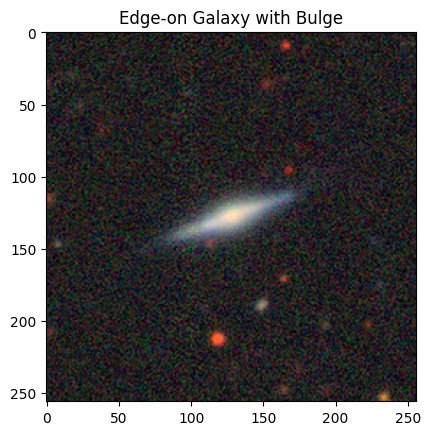

In [66]:
number = 17735
numpy_img = images[number]
plt.title(classes_names[classes[number]])
plt.imshow(numpy_img)
print(numpy_img.shape)
plt.show()

In [67]:
binary_classes_names = {
                    0: classes_names[2],
                    1: classes_names[9]
                 }

In [68]:
labels  = np.concatenate([np.zeros(5579 - 2934), np.ones(17736 - 15863)], axis=0) #перекодируем 2 в 0, 9 в 1
labels_ = np.zeros([4518, 2])

In [69]:
for i in range(4518):
    row = np.zeros(2)
    if labels[i] == 1:
        row[1] = 1
    else:
        row[0] = 1
    labels_[i] = row

In [70]:
labels_

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [71]:
labels_binary = torch.tensor(labels_, dtype=torch.float32)
#labels_binary = torch.tensor(labels, dtype=torch.float32)
images_binary = torch.tensor(np.concatenate([images[2934:5579], images[15863:17736]], axis=0), dtype=torch.float32)

In [72]:
images_binary = images_binary.reshape([4518, 3, 256, 256])

In [73]:
dataset = torch.utils.data.TensorDataset(images_binary, labels_binary)

In [74]:
train_set, test_set = train_test_split(dataset, test_size=0.2)

In [75]:
batch_size = 4
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=2)
test_loader  = torch.utils.data.DataLoader(test_set,  batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
# я запихал все в dataloader, но возникает вопрос - нужно ли делать reshape, 
# ибо один батч с картинками имеет shape (4, 256, 256, 3), а должно вроде быть (4, 3, 256, 256)
for image, label in train_loader:
    #print(image.shape, label[0])
    #print(label.numpy()[0])
    plt.imshow(image[0].reshape([256, 256, 3]))
    #print(label[0])
    #plt.title(classes[label.numpy()[0]])
    break

In [77]:
def train(model, train_loader, criterion, optimizer, losses, num_epochs=100):
    for epoch in range(num_epochs):
        running_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            #print(images.dtype)
            output = model(images)
            #print(labels, output)
            loss = criterion(output, labels)
            running_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #scheduler.step()
        losses.append(running_loss)
        print(f"Epoch {epoch + 1} / {num_epochs}")
    print('Training is finished')
    return model

In [83]:
def predict(model, test_loader):
  n_samples = 0
  n_correct = 0
  n_class_samples = np.zeros(2)
  n_class_correct = np.zeros(2)
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
      output = model(images)
    #print(output)
    _, predictions = torch.max(output, -1)
    n_samples += labels.size(0)
    #print(predictions)
    #print(labels)
    
    n_correct += sum([labels[k][int(predictions[k])] == 1.0 for k in range(batch_size)])
    
    for i in range(labels.shape[0]):
      label = labels[i]
      for k, elem in enumerate(label):
        if elem == 1.0:
          label_ = k
        #print(label_)
      pred = predictions[i]
      if (label_ == pred):
        n_class_correct[label_] += 1
      n_class_samples[label_] += 1

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {binary_classes_names[i]}: {acc} %')

In [84]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [85]:
# using pretrained resnet 18 with last layer fine tuning
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [86]:
losses = list()
criterion = nn.MSELoss()
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)
lr_step = 3 * 10 ** -4
model = model.to(device)

In [87]:
model = train(model, train_loader, criterion, optimizer, losses, num_epochs=10)

Epoch 1 / 10
Epoch 2 / 10
Epoch 3 / 10
Epoch 4 / 10
Epoch 5 / 10
Epoch 6 / 10
Epoch 7 / 10
Epoch 8 / 10
Epoch 9 / 10
Epoch 10 / 10
Training is finished


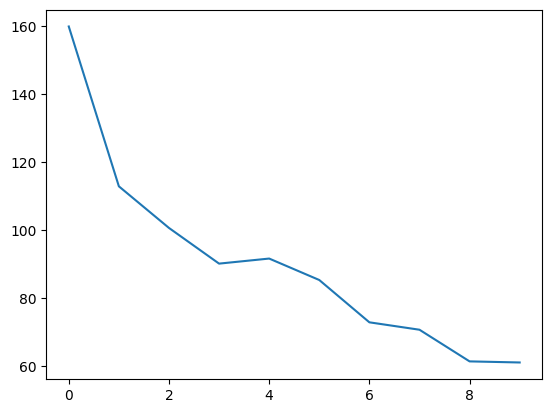

In [88]:
plt.plot(np.arange(len(losses)), losses)
plt.show()

In [89]:
predict(model, test_loader)

Accuracy of the network: 86.9468994140625 %
Accuracy of Round Smooth Galaxy: 78.30188679245283 %
Accuracy of Edge-on Galaxy with Bulge: 99.19786096256685 %


In [90]:
n_qubits = 4
q_depth = 6
q_delta = 0.01

In [91]:
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, interface="torch")
def quantum_circuit(q_input_features, q_weights_flat):
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)
    for i in range(n_qubits):
        qml.Hadamard(wires=i)
        qml.RY(q_input_features[i], wires=i)
    for k in range(q_depth):
        for i in range(n_qubits - 1):
            qml.CNOT(wires=[i, i + 1])
        for i in range(n_qubits):
            qml.RY(q_weights[k][i], wires=i)
            qml.RX(q_weights[k][i], wires=i)
            qml.RZ(q_weights[k][i], wires=i)    
    return list(qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits))

In [92]:
class QuantumNet(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.classical_layer = nn.Linear(num_ftrs, n_qubits)
        self.q_params = nn.Parameter(q_delta * torch.randn(q_depth * n_qubits))
        self.classificator = nn.Linear(4, 2)
    
    def forward(self, input_features=512):
        pre_out = self.classical_layer(input_features)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = quantum_circuit(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        # return the two-dimensional prediction from the postprocessing layer
        return self.classificator(q_out)

In [93]:
model_hybrid = models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.fc = QuantumNet()

model_hybrid = model_hybrid.to(device)

optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=lr_step)
losses_hybrid = list()
criterion = nn.CrossEntropyLoss()

In [94]:
model_hybrid = train(model_hybrid, train_loader, criterion, optimizer_hybrid, losses_hybrid, num_epochs=10)

Epoch 1 / 10
Epoch 2 / 10
Epoch 3 / 10
Epoch 4 / 10
Epoch 5 / 10
Epoch 6 / 10
Epoch 7 / 10
Epoch 8 / 10
Epoch 9 / 10
Epoch 10 / 10
Training is finished


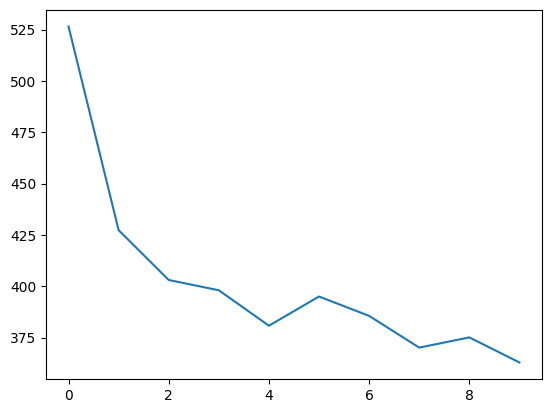

In [95]:
plt.plot(np.arange(len(losses_hybrid)), losses_hybrid)
plt.show()

In [96]:
predict(model_hybrid, test_loader)

Accuracy of the network: 83.18584442138672 %
Accuracy of Round Smooth Galaxy: 88.49056603773585 %
Accuracy of Edge-on Galaxy with Bulge: 75.66844919786097 %
